In [10]:
from openket import *
from scipy.integrate import odeint
from sympy import var, I
import numpy as np
import matplotlib.pyplot as plt
import math

In [11]:
hbar = 1.0
omega_c = 1.5  # frecuencia de la cavidad (unidad de referencia)
omega_b = 1.0 # frecuencia del bombeo, inyección de energía desde el láser externo (unidad de referencia)
rabi_b = 2.0 # tasa del bombeo, proporcional a la amplitud del campo eléctrico del láser
detuning = omega_c - omega_b # detuning entre frecuencia de la cavidad y frecuencia del láser

kappa = 0.1
alpha = 1
nmax = 5 # truncación del espacio de Hilbert (número de estados de Fock)
dt = 1000
t = np.linspace(0, 15, dt)

base = [Ket(i, "campo") for i in range(nmax)]
rho = Operator("R")
a = AnnihilationOperator("campo", nmax-1)
aa = CreationOperator("campo", nmax-1)

In [12]:
# Condición inicial: estado coherente |alpha⟩
state_alpha = 0
for i in range(nmax):
        state_alpha = state_alpha + ((alpha**2) / math.sqrt(math.factorial(i))) * Ket(i,"campo")
state_alpha = np.exp(-(np.abs(alpha)**2)/2) * state_alpha
#rho0 = state_alpha * dag(state_alpha)
rho0 = Ket(0,"campo") * dag(Ket(0,"campo"))

In [13]:
H_c = hbar * detuning * (aa * a + 1 / 2) # Hamiltoniano del oscilador armónico cuántico (cavidad)
H_b = I*hbar * rabi_b * (aa - a) # Hamiltoniano del bombeo (láser)
H = H_c + H_b # Hamiltoniano total
# ecuación de movimiento de Lindblad
rdot = I/hbar * comm(H,rho) + (kappa/2)*(2*a*rho*aa - aa*a*rho - rho*aa*a)

build_ode(rho=rho, rdot=rdot, basis=base, filetype="Scipy", filename="func.py")

In [14]:
from func import dic, f
# convertir condiciones iniciales simbólicas -> numéricas
init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
# solución numérica
rho_solution = odeint(f, init_conditions, t)

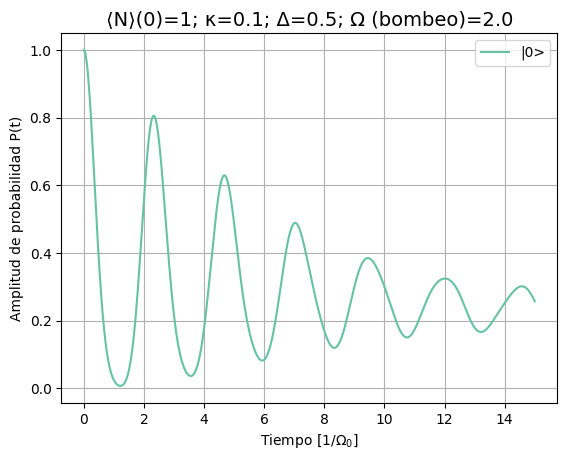

In [15]:
# Probabilidad
rho_complex = rho_solution[:, ::2] + 1j * rho_solution[:, 1::2] # convierte la matriz a entradas complejas
rho_complex = rho_complex.reshape(dt, nmax, nmax) # pasa de matriz plana a matriz densidad nxn para cada t
rho_nn = np.diagonal(np.abs(rho_complex), axis1=1, axis2=2) # extrae los elementos diagonales

estados = [0]
for i in estados:
    plt.plot(t, rho_nn[:,i], label=f'|{i}>', color=cmap(i))
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Amplitud de probabilidad P(t)')
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Valores esperados
# definición simbólica de los observables
N = aa * a # operador de número
X = (1/np.sqrt(2)) * (a+aa) # cuadratura X adimensional
P = (1/np.sqrt(2)) * I*(aa-a) # cuadratura P adimensional

N_symb = sub_qexpr(qexpr=trace(rho * N, basis=base), dic=dic)
X_symb = sub_qexpr(qexpr=trace(rho * X, basis=base), dic=dic)
P_symb = sub_qexpr(qexpr=trace(rho * P, basis=base), dic=dic)

N_expect = sym2num(sol=rho_solution, symbexpr=N_symb)
X_expect = sym2num(sol=rho_solution, symbexpr=X_symb)
P_expect = sym2num(sol=rho_solution, symbexpr=P_symb)

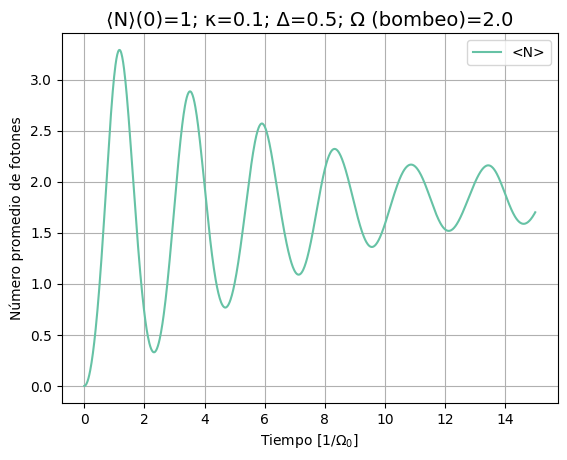

In [8]:
plt.plot(t, np.real(N_expect), label='<N>', color=cmap(0))
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Número promedio de fotones')
plt.legend()
plt.grid()
plt.show()

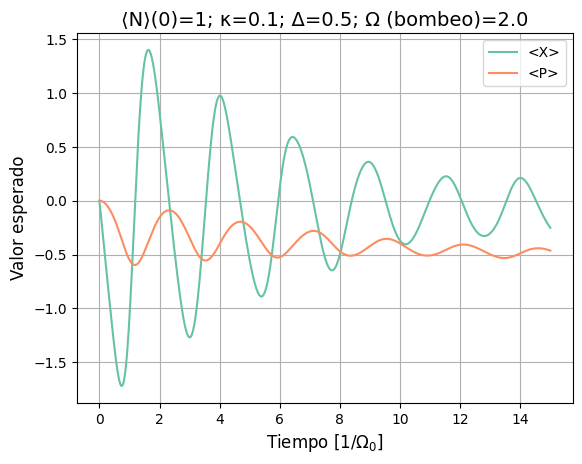

In [9]:
plt.plot(t, np.real(X_expect), label='<X>', color=cmap(0))
plt.plot(t, np.real(P_expect), label='<P>', color=cmap(1))
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]', fontsize=12)
plt.ylabel('Valor esperado', fontsize=12)
plt.legend()
plt.grid()
plt.show()